In [1]:
import numpy as np
import math
import heapq
import ray
from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete
from ray import tune, rllib, air
from ray.rllib.algorithms.ppo import PPOConfig
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ray.tune.registry import register_env
from ray.rllib.utils.pre_checks.env import check_env

In [9]:
# define the custom routing grid environemnt
# observation_space

# action_space
    # 0 - > move up
    # 1 - > move down
    # 2 - > move right
    # 3 - > move left


class RtGridEnv(Env):
    def __init__(self, length, width, nets, macros):
        """
        Args:
            length (int): length of the canvas
            width (int): width of the canvas
            nets (list): a list of nets to be routed
            macros (list): a list of macros that has been placed on the canvas by placement
        """
        self.length = length
        self.width = width

        self.nets = nets
        self.macros = macros

        self.pin_counter = 0 # counts the number of pins within a net that have been routed
        self.net_counter = 0 # counts the number of nets that have been routed

        self.path_x = [[] for _ in range(len(self.nets))] # holds the x coordinates of the path for each net as a sub-list
        self.path_y = [[] for _ in range(len(self.nets))] 

        # decompose the multi-pin nets into 2-pin nets
        self.decomposed_nets = []
        for net in self.nets:
            self.decomposed_nets.append(self.prim_mst(net))
        #print(self.decomposed_nets)
        #print(self.macros)

        # initialize the agent to route the first 2-pin net decompsoed from the first multi-pin net
        self.update_positions()

        # initialize the path lists
        self.update_path()

        # define the action and the observation space
        self.action_space = Discrete(4)
        self.observation_space = MultiDiscrete([self.length, self.width])

        #print("initial agent position: ", self.agent_position)
        #print("initial goal position: ", self.goal_position)
        #print("initial path x: ", self.path_x)
        #print("initial path y: ", self.path_y)

        # Define the position and size of the rectangle obstacle
        self.rect_x = 1
        self.rect_y = 0
        self.rect_length = 2
        self.rect_width = 2

        self.obst_x_range = np.array(range(self.rect_x, self.rect_x+self.rect_length+1))
        self.obst_y_range = np.array(range(self.rect_y, self.rect_y+self.rect_width+1))

    def prim_mst(self, pins):
        """
        Compute the Minimum Spanning Tree (MST) using Prim's algorithm.

        Args:
            pins (list): List of (x, y) coordinates representing the pin locations.

        Returns:
            dict: a dictionary containing the vertices of all the edges in the MST

        Note:
            - The pins list should contain at least two points.
        """

        def euclidean_distance(p1, p2):
            """
            Compute the Euclidean distance between two points.

            Args:
                p1 (tuple): First point (x, y) coordinates.
                p2 (tuple): Second point (x, y) coordinates.

            Returns:
                float: Euclidean distance between the two points.
            """
            x1, y1 = p1
            x2, y2 = p2
            return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        
        distances = {}
        for i in range(len(pins)):
            for j in range(i+1, len(pins)):
                p1 = pins[i]
                p2 = pins[j]
                distances[(i, j)] = euclidean_distance(p1, p2)
        
        # Initialize
        num_pins = len(pins)
        visited = [False] * num_pins
        mst_u = []
        mst_v = []
        start_vertex = 0
        visited[start_vertex] = True
        
        # Create a priority queue
        pq = []
        
        # Mark the initial vertex as visited
        for i in range(num_pins):
            if i != start_vertex:
                heapq.heappush(pq, (distances[(start_vertex, i)], start_vertex, i))
        
        # Print initial priority queue
        #print("Initial priority queue:")
        #for item in pq:
            #print(item)
        #print()
        
        # Update the priority queue and perform Prim's algorithm
        while pq:
            if (len(mst_u) == len(pins) -1): # for n pins, the MST should at most have n-1 edges
                break

            weight, u, v = heapq.heappop(pq)
            #print("Selected edge:")
            #print(weight, u, v)
            #print()
            
            if visited[v]:
                #print(f"Skipping edge: {weight} - {u} - {v}")
                continue
            
            # Prim's algorithm iteration
            visited[v] = True
            #print("u:",u)
            #print("v:",v)
            mst_u.append(pins[u])
            mst_v.append(pins[v])
            
            for i in range(num_pins):
                if not visited[i]:
                    heapq.heappush(pq, (distances[(v, i)], v, i))
        
        mst = {'u':mst_u,'v':mst_v}

        return mst
    
    def update_counters(self):
        # one 2-pin net within one multi-pin net is done
        done = False
        self.pin_counter += 1

        if self.pin_counter == len(self.nets[self.net_counter]) - 1:
            # this multi-pin net is done
            self.pin_counter = 0
            self.net_counter += 1
            if self.net_counter == len(self.nets):
                # all nets are done, raise the done flag
                done = True

        return done
    
    def update_positions(self):
        """
        Update the positions of the agent and the goal, based on counter values, i.e., the progess of the episode
        """
        self.agent_position = np.array(self.decomposed_nets[self.net_counter]['u'][self.pin_counter])
        self.goal_position = np.array(self.decomposed_nets[self.net_counter]['v'][self.pin_counter])

    def update_path(self):
        """
        Update the routing path travelled by the agent, routes for different nets are stored in separated lists
        """
        self.path_x[self.net_counter].append(self.agent_position[0])
        self.path_y[self.net_counter].append(self.agent_position[1])

    def step(self, action):
        def check_obstacle(x,y):
            """
            Check whether a point (x,y) is within the obstacle area, returns True if the point is within obstacles, Flase if not
            """
            is_present = (x,y) in self.macros

            return is_present
        
        done = False

        '''print("1 position ", self.agent_position)
        print("1 pin ",self.pin_counter)
        print("1 net ",self.net_counter)
        print("1 path x ", self.path_x)
        print("1 path y ",self.path_y)'''

        if action == 0:  # Up
            if ((self.agent_position[1] + 1) <= self.width - 1) and not check_obstacle(self.agent_position[0], self.agent_position[1] + 1): # if within the bound, then accept the move
                self.agent_position[1] = self.agent_position[1] + 1
        elif action == 1:  # Down
            if ((self.agent_position[1] - 1) >= 0) and not check_obstacle(self.agent_position[0], self.agent_position[1] - 1):
                self.agent_position[1] = self.agent_position[1] - 1
        elif action == 2:  # Right
            if ((self.agent_position[0] + 1) <= self.length - 1) and not check_obstacle(self.agent_position[0] + 1, self.agent_position[1]):
                self.agent_position[0] = self.agent_position[0] + 1
        elif action == 3:  # Left
            if ((self.agent_position[0] - 1) >= 0) and not check_obstacle(self.agent_position[0] - 1, self.agent_position[1]):
                self.agent_position[0] = self.agent_position[0] - 1

        self.update_path()

        '''print("2 position ", self.agent_position)
        print("2 pin ",self.pin_counter)
        print("2 net ",self.net_counter)
        print("2 path x ", self.path_x)
        print("2 path y ",self.path_y)'''

        if np.array_equal(self.agent_position, self.goal_position):
            reward = 10
            done = self.update_counters()
            if not done:
                self.update_positions()
                self.update_path()
        else:
            reward = -1
        
        #if not done:
            #self.update_path()

        #done = np.array_equal(self.agent_position, self.goal_position)
        #reward = 10 if done else -1

        # Update the agent's path
        #self.path_x.append(self.agent_position[0])  
        #self.path_y.append(self.agent_position[1])  

        return self.agent_position, reward, done, {}
    
    def render(self):
        """
        Plot the agent's path
        """
        # Create a new figure and axis
        #fig, ax = plt.subplots()

        # Create a Rectangle patch
        #rectangle = patches.Rectangle((self.rect_x, self.rect_y), self.rect_length, self.rect_width, linewidth=1, edgecolor='g', facecolor='g')

        # Add the rectangle to the axis
        #ax.add_patch(rectangle)

        # Plot the agent path
        #print(self.path_x)
        #print(self.path_y)
        for net in range(len(self.path_x)):
            plt.plot(self.path_x[net], self.path_y[net])

        # plot the pins
        for net in self.nets:
            x_coords, y_coords = zip(*net)
            plt.scatter(x_coords, y_coords)

        # plot the macro pins
        for point in self.macros:
            x, y = point
            plt.scatter(x,y, color='green')

        # Set the labels and title
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Nets')

        # Set the x and y axis limits
        #plt.xlim(0, self.length-1)
        #plt.ylim(0, self.width-1)

        # Set the x and y axis ticks
        plt.xticks(range(0, self.length))
        plt.yticks(range(0, self.width))

        # Set the grid
        plt.grid(color='blue', linestyle='--', linewidth=0.5)

        # Show the plot
        plt.show()

    def reset(self):
        self.pin_counter = 0
        self.net_counter = 0
        self.path_x = [[] for _ in range(len(self.nets))]
        self.path_y = [[] for _ in range(len(self.nets))]
        self.update_positions()
        self.update_path()
        return self.agent_position

-76


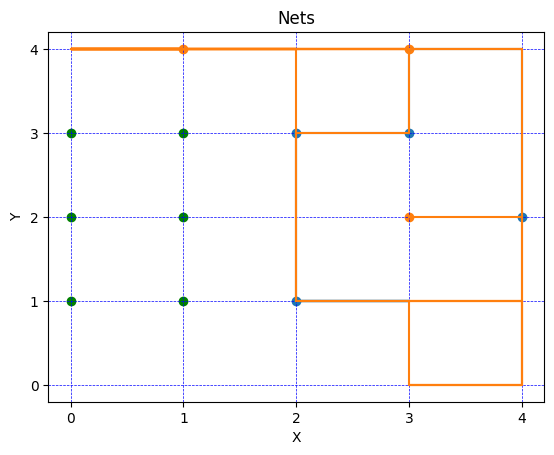

-47


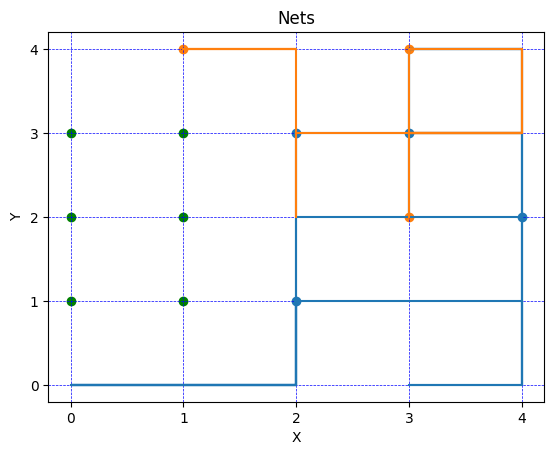

-30


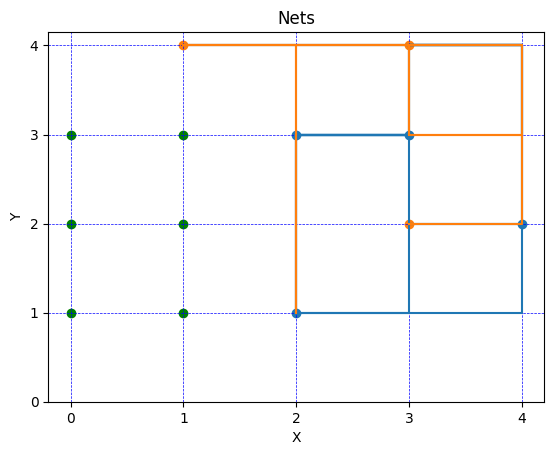

In [10]:
nets = [[(2,1), (2,3), (3,3), (4,2)],[(1,4), (3,4), (3,2)]]
macros = [(0,1), (0,2), (0,3), (1,1), (1,2), (1,3)]
env = RtGridEnv(5,5,nets, macros)
num_episodes = 3

for ep in range(num_episodes):
    total_reward = 0
    obs = env.reset()
    done = False
    while True:
        action = env.action_space.sample()
        new_obs, reward, done, info = env.step(action)
        total_reward += reward
            
        #print(f"episode: {ep}")
        #print(f"obs: {new_obs}, reward: {total_reward}, done: {done}")

        if done:
            break
    print(total_reward)
    env.render()

In [12]:
# check the environment
register_env("routing_grid_env", lambda config: RtGridEnv(5,5,nets, macros))
env = RtGridEnv(5,5,nets, macros)

print("checking environment ...")
try:
    check_env(env)
    print("All checks passed. No errors found.")
except:
    print("failed")
    print(check_env(env))

2023-06-27 10:05:34,386	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


checking environment ...
All checks passed. No errors found.


In [13]:
# configure a new agent based on the tuning results obtained above
config2 = (
    PPOConfig()
    .environment(env = "routing_grid_env")
    .rollouts(num_rollout_workers=2)
    .evaluation(evaluation_interval=15, evaluation_duration=5, evaluation_num_workers=1)
    .training(lr=0.00005)
)
algo = config2.build()

2023-06-27 10:05:39,531	INFO worker.py:1538 -- Started a local Ray instance.
(RolloutWorker pid=4564) 2023-06-27 10:05:43,226	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=4690) 2023-06-27 10:05:47,077	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-06-27 10:05:47,641	INFO trainable.py:172 -- Trainable.setup took 10.116 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-27 10:05:47,642	WARNING util.py:66 -- Install gputil for GPU system monitoring.


In [17]:
# train the new agent using RLlib.train() in a loop
num_iterations = 20
rewards = []
checkpoint_dir = "saved_runs/MultiPinNets/"

for i in range(num_iterations):
    result = algo.train()
    rewards.append(result["episode_reward_mean"])

    # save a checkpoint and evaluate the policy at the end of the training
    if (i==num_iterations-1):
        checkpoint_file = algo.save(checkpoint_dir)
        eval_result = algo.evaluate()
print(rewards)

[43.72990353697749, 43.832402234636874, 22.045751633986928, 43.98, 21.84561403508772, 42.88181818181818, 43.78431372549019, 43.792717086834735, 33.1219512195122, 22.609756097560975, 43.905, 27.358851674641148, 43.84679665738162, 44.6015625, 44.41798941798942, 44.75447570332481, 45.17329545454545, 45.11330049261084, 45.56603773584906, 45.60377358490566]


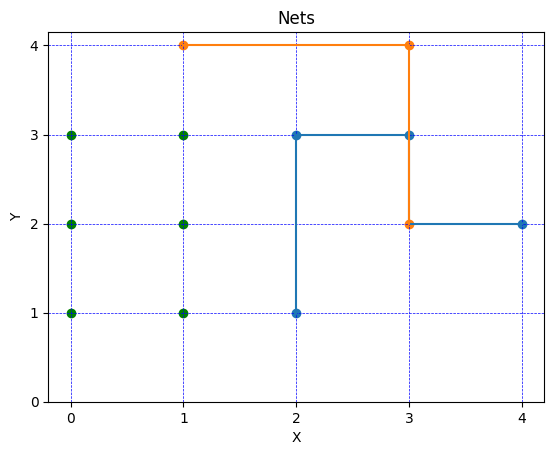

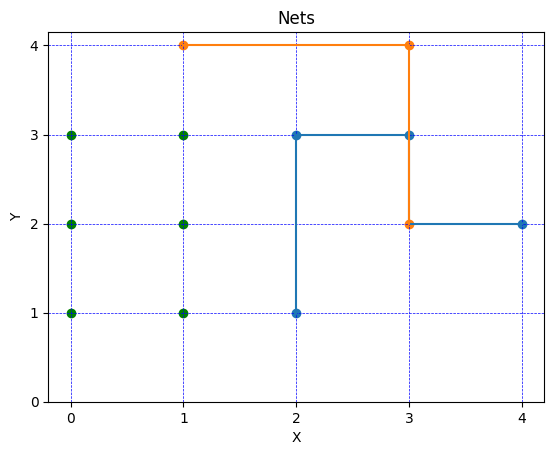

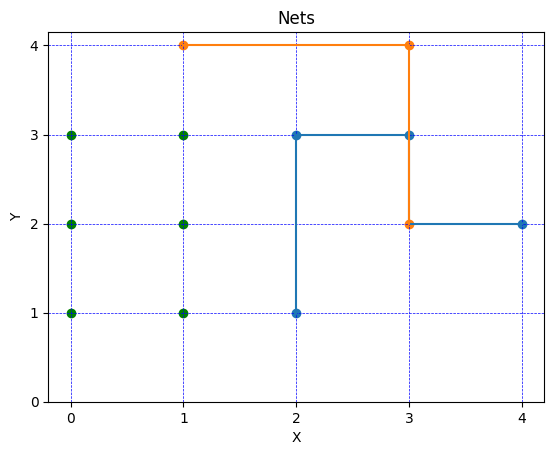

In [18]:
# play and render the game
num_episodes = 3
total_reward = 0

for ep in range(num_episodes):
    obs = env.reset()
    done = False
    while True:
        action = algo.compute_single_action(observation=obs, explore=False)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        
        if done:
            break
        
        #print(f"episode: {ep}")
        #print(f"obs: {new_obs}, reward: {total_reward}, done: {done}")
    env.render()
#env.close()